# ***ATTENZIONE***
In tutto il notebook gli outliers sono stati indicati con -1 all interno del dataset, gli inlier con 1.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from collections import Counter
from collections import defaultdict

from sklearn.preprocessing import StandardScaler

from pyod.models.hbos import HBOS

from sklearn.covariance import EllipticEnvelope

from pyod.models.knn import KNN

from sklearn.neighbors import LocalOutlierFactor

from pyod.models.cof import COF

from sklearn.cluster import DBSCAN

from pyod.models.cblof import CBLOF

from pyod.models.abod import ABOD

from pyod.models.loda import LODA

from sklearn.ensemble import IsolationForest
from pyod.models.iforest import IsolationForest

In [2]:
df_train=pd.read_csv("RavdessAudioOnlyFeatures_TRAIN.csv")
df_test=pd.read_csv("RavdessAudioOnlyFeatures_TEST.csv")

df_train["emotion"]=df_train["emotion"].replace(["fearful", "angry", "happy", "surprised", "neutral", "calm", "sad", "disgust"],[0,1,2,3,4,5,6,7])
df_train["emotional_intensity"]=df_train["emotional_intensity"].replace(["normal", "strong"],[0,1])
df_train["sex"]=df_train["sex"].replace(["M", "F"],[0,1])
df_train["statement"]=df_train["statement"].replace(["Dogs are sitting by the door", "Kids are talking by the door"],[0,1])
df_train["vocal_channel"]=df_train["vocal_channel"].replace(["speech", "song"],[0,1])
y_train=df_train.emotion.values
X_train=df_train.drop(columns=["emotion", "modality","emotional_intensity","sex","statement","vocal_channel","repetition","actor","filename"]).values

df_test["emotion"]=df_test["emotion"].replace(["fearful", "angry", "happy", "surprised", "neutral", "calm", "sad", "disgust"],[0,1,2,3,4,5,6,7])
df_test["emotional_intensity"]=df_test["emotional_intensity"].replace(["normal", "strong"],[0,1])
df_test["sex"]=df_test["sex"].replace(["M", "F"],[0,1])
df_test["statement"]=df_test["statement"].replace(["Dogs are sitting by the door", "Kids are talking by the door"],[0,1])
df_test["vocal_channel"]=df_test["vocal_channel"].replace(["speech", "song"],[0,1])
y_test=df_test.emotion.values
X_test=df_test.drop(columns=["emotion", "modality","emotional_intensity","sex","statement","vocal_channel","repetition","actor","filename"]).values


In [3]:
frames = [df_train, df_test]
df = pd.concat(frames)
X = df.drop(columns=["emotion", "modality","emotional_intensity","sex","statement","vocal_channel","repetition","actor","filename"]).values
X_unscaled = df.drop(columns=["emotion", "modality","emotional_intensity","sex","statement","vocal_channel","repetition","actor","filename"]).values
y=df.emotion.values

In [4]:
scl = StandardScaler()
X = scl.fit_transform(X)

# Visual Based

## HBOS

In [5]:
clf = HBOS(n_bins=20)
clf.fit(X)
clf.decision_scores_

array([544.47812809, 516.3929836 , 513.85619131, ..., 557.42283041,
       553.92719326, 600.52194469])

In [6]:
outliers = clf.predict(X)
print(np.unique(outliers, return_counts=True))
print(np.unique(outliers, return_counts=True)[1][1]/len(X))

(array([0, 1]), array([2206,  246]))
0.100326264274062


In [7]:
for i in range(len(outliers)):
    if outliers[i] == 1:
        outliers[i] = -1
    else:
        outliers[i] = 1
outliers

array([1, 1, 1, ..., 1, 1, 1])

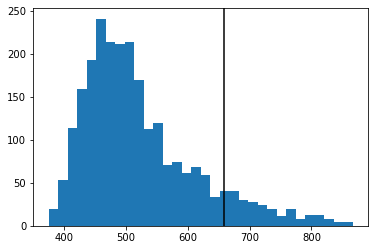

In [8]:
plt.hist(clf.decision_scores_, bins="auto")
plt.axvline(np.min(clf.decision_scores_[np.where(outliers==-1)]), c='k')
plt.show()

# Depth Based

## Elliptic Envelope

In [9]:
ellenv = EllipticEnvelope(random_state=0)
ellenv.fit(X)
outliers = ellenv.predict(X)

/Users/jacopogneri/opt/anaconda3/lib/python3.9/site-packages/sklearn/covariance/_robust_covariance.py:738: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


In [10]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([ 246, 2206]))

In [11]:
#df["outliers_elliptic_envelope"] = outliers

In [12]:
#df.iloc[np.where(df.outliers_elliptic_envelope == -1)].head()

# Distance Based

## KNN

In [13]:
from pyod.models.knn import KNN

In [14]:
clf = KNN(n_neighbors=5)  #method="largest",
clf.fit(X)

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [15]:
outliers = clf.predict(X)
np.unique(outliers, return_counts=True)

(array([0, 1]), array([2222,  230]))

In [16]:
for i in range(len(outliers)):
    if outliers[i] == 0:
        outliers[i] = 1
    else:
        outliers[i] = -1
outliers

array([-1,  1,  1, ...,  1,  1,  1])

In [17]:
#df["outliers_knn"] = outliers

In [18]:
#df.iloc[np.where(df.outliers_knn == -1)].head()

In [19]:
'''
outliers_list_knn = []
for i in range(2,50):
    clf = KNN(n_neighbors=i, method="largest", p=2, n_jobs=-1)
    clf.fit(X)
    outliers = clf.predict(X)
    outliers_list_knn.append(np.unique(outliers, return_counts=True)[1][1])

plt.scatter(x=np.arange(2,50), y=outliers_list_knn)
plt.show()
'''
#tempo di esecuzione circa 2 minuti

'\noutliers_list_knn = []\nfor i in range(2,50):\n    clf = KNN(n_neighbors=i, method="largest", p=2, n_jobs=-1)\n    clf.fit(X)\n    outliers = clf.predict(X)\n    outliers_list_knn.append(np.unique(outliers, return_counts=True)[1][1])\n\nplt.scatter(x=np.arange(2,50), y=outliers_list_knn)\nplt.show()\n'

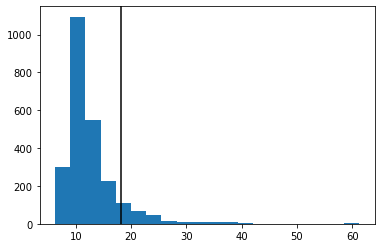

In [20]:
plt.hist(clf.decision_scores_, bins=20)
plt.axvline(np.min(clf.decision_scores_[np.where(outliers==-1)]), c='k')
plt.show()

# Density Based

## LOF

In [21]:
clf = LocalOutlierFactor(n_neighbors=3)
clf.fit(X)

LocalOutlierFactor(n_neighbors=3)

In [22]:
outliers = clf.fit_predict(X)
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([  80, 2372]))

In [23]:
'''
outliers_list_lof = []
for i in range(1,300):
    clf = LocalOutlierFactor(n_neighbors=i, novelty = False)
    clf.fit(X)
    outliers = clf.fit_predict(X)
    outliers_list_lof.append(np.unique(outliers, return_counts=True)[1][0])

plt.scatter(x=np.arange(1,300), y=outliers_list_lof)
plt.show()
'''
#tempo di esecuzione circa 2m40s. Minimo per n_neighbor=3 con 64 outliers

'\noutliers_list_lof = []\nfor i in range(1,300):\n    clf = LocalOutlierFactor(n_neighbors=i, novelty = False)\n    clf.fit(X)\n    outliers = clf.fit_predict(X)\n    outliers_list_lof.append(np.unique(outliers, return_counts=True)[1][0])\n\nplt.scatter(x=np.arange(1,300), y=outliers_list_lof)\nplt.show()\n'

In [24]:
NLOF = clf.negative_outlier_factor_ #the higher the more normal
ind = np.argpartition(NLOF, int(len(df)*0.01))[:int(len(df)*0.01)] # indice dei top 1% outliers
ind

array([1604, 1979, 2046, 1957, 1556,  382, 1702, 1968, 1766, 1765,  636,
        223, 1704, 1496, 1862,  942,  589,  826, 1296,   42, 1738, 1970,
        234, 1762])

In [25]:
df["outliers_LOF"] = 0
for i in range(len(df)):
    if i in ind:
        df["outliers_LOF"][i] = -1
    else:
        df["outliers_LOF"][i] = 1

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LOF"][i] = -1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["o

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ou

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ou

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ou

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ou

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ou

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ou

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ou

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ou

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ou

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ou

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ou

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ou

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ou

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ou

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ou

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ou

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ou

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ou

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ou

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/4215259980.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ou

In [26]:
df.iloc[np.where(df.outliers_LOF == -1)].head()

,modality,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,sex,filename,frame_count,...,stft_q01_w4,stft_q05_w4,stft_q25_w4,stft_q50_w4,stft_q75_w4,stft_q95_w4,stft_q99_w4,stft_kur_w4,stft_skew_w4,outliers_LOF
42,audio-only,0,0,1,0,1st,1,0,03-01-06-02-02-01-01.wav,190590,...,0.134137,0.202314,0.347175,0.513084,0.741968,1.000000,1.0,-0.961270,0.331694,-1
223,audio-only,0,2,0,0,2nd,3,0,03-01-03-01-02-02-03.wav,168168,...,0.119016,0.191970,0.365234,0.577819,0.800783,1.000000,1.0,-1.114115,0.025413,-1
234,audio-only,0,6,1,0,1st,3,0,03-01-04-02-02-01-03.wav,166566,...,0.074704,0.218413,0.597664,0.792696,0.924666,1.000000,1.0,0.156586,-0.969812,-1
382,audio-only,1,5,1,0,1st,4,1,03-02-02-02-02-01-04.wav,283483,...,0.000000,0.000000,0.000000,0.000000,0.017445,0.839625,1.0,6.294618,2.725187,-1
589,audio-only,1,5,1,1,2nd,6,1,03-02-02-02-01-02-06.wav,304304,...,0.000000,0.000000,0.000000,0.000000,0.007891,0.858079,1.0,7.127631,2.880807,-1


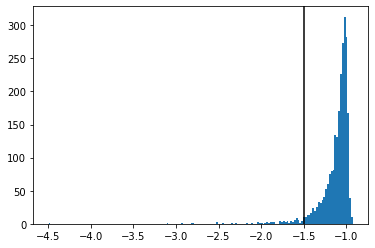

In [27]:
plt.hist(clf.negative_outlier_factor_, bins="auto")
plt.axvline(np.min(clf.negative_outlier_factor_[np.where(outliers==1)]), c='k')
plt.show()

## COF

In [28]:
clf = COF(n_neighbors=5)
clf.fit(X)


COF(contamination=0.1, method='fast', n_neighbors=None)

In [29]:
outliers = clf.predict(X)
np.unique(outliers, return_counts=True)

(array([0, 1]), array([2206,  246]))

In [30]:
for i in range(len(outliers)):
    if outliers[i] == 0:
        outliers[i] = 1
    else:
        outliers[i] = -1
outliers

array([-1, -1,  1, ...,  1,  1,  1])

In [31]:
#df["outliers_cof"] = outliers

In [32]:
#df.iloc[np.where(df.outliers_cof == -1)]

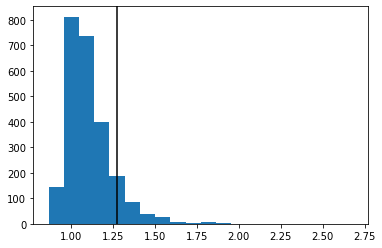

In [33]:
plt.hist(clf.decision_scores_, bins=20)
plt.axvline(np.min(clf.decision_scores_[np.where(outliers==-1)]), c='k')
plt.show()

# Cluster Based

## DBSCAN

In [34]:
outliers=[]
for i in range(1,50):    
    dbscan = DBSCAN(eps=i, min_samples=5)
    dbscan.fit(X)
    outliers.append((dbscan.labels_==-1).sum())

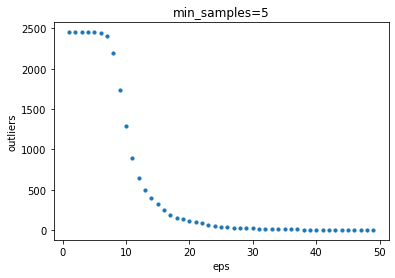

In [35]:
plt.scatter(x=range(1,50), y=outliers, s=10)
plt.xlabel("eps")
plt.ylabel("outliers")
plt.title("min_samples=5")
plt.show()

## CBLOF

In [36]:

outliers_list_cblof = []
for i in range(3,30):
    clf = CBLOF(n_clusters=i, alpha=0.75, beta=3)
    clf.fit(X)
    outliers = clf.predict(X)
    outliers_list_cblof.append(np.unique(outliers, return_counts=True)[1][1])

outliers_list_cblof


[246,
 246,
 246,
 246,
 246,
 246,
 246,
 246,
 246,
 246,
 246,
 246,
 246,
 246,
 246,
 246,
 246,
 246,
 246,
 246,
 246,
 246,
 246,
 246,
 246,
 246,
 246]

In [37]:
OS = clf.decision_scores_ #the lower the more normal
ind = np.argpartition(OS, -int(len(df)*0.01))[-int(len(df)*0.01):] # indice dei top 1% outliers
ind

array([ 361, 1766,  292,  311,  309, 1862, 2046, 1497,   42, 1496, 1556,
        382,  589, 1738, 1968, 1281,  942, 1160,  841, 1704, 1480, 1296,
       1957, 1979])

In [38]:
df["outliers_CBLOF"] = 0
for i in range(len(df)):
    if i in ind:
        df["outliers_CBLOF"][i] = -1
    else:
        df["outliers_CBLOF"][i] = 1

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_CBLOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_CBLOF"][i] = -1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_CBLOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_CBLOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_CBLOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_CBLOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_CBLOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_CBLOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_CBLOF"][i] = -1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_CBLOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_CBLOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_CBLOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_CBLOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_CBLOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_CBLOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_CBLOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_CBLOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_CBLOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_CBLOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_CBLOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_CBLOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_CBLOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_CBLOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_CBLOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_CBLOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_CBLOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_CBLOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_CBLOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_CBLOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_CBLOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_CBLOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_CBLOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_CBLOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_CBLOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_CBLOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_CBLOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_CBLOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_CBLOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_CBLOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_CBLOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_CBLOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_CBLOF"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3000840312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df

In [39]:
df.iloc[np.where(df.outliers_CBLOF == -1)].head()

,modality,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,sex,filename,frame_count,...,stft_q05_w4,stft_q25_w4,stft_q50_w4,stft_q75_w4,stft_q95_w4,stft_q99_w4,stft_kur_w4,stft_skew_w4,outliers_LOF,outliers_CBLOF
42,audio-only,0,0,1,0,1st,1,0,03-01-06-02-02-01-01.wav,190590,...,0.202314,0.347175,0.513084,0.741968,1.0,1.0,-0.961270,0.331694,-1,-1
292,audio-only,1,6,1,1,1st,3,0,03-02-04-02-01-01-03.wav,224224,...,0.032890,0.624804,0.845093,0.959539,1.0,1.0,0.265560,-1.229529,1,-1
309,audio-only,1,0,1,1,2nd,3,0,03-02-06-02-01-02-03.wav,201801,...,0.112738,0.319031,0.534023,0.776338,1.0,1.0,-1.130088,0.051363,1,-1
311,audio-only,1,0,1,0,2nd,3,0,03-02-06-02-02-02-03.wav,198598,...,0.168805,0.372828,0.620822,0.866391,1.0,1.0,-1.195729,-0.167501,1,-1
361,audio-only,0,7,1,1,2nd,4,1,03-01-07-02-01-02-04.wav,193794,...,0.169967,0.486224,0.676860,0.833959,1.0,1.0,-0.625791,-0.506131,1,-1


In [40]:
outliers

array([1, 0, 0, ..., 0, 0, 0])

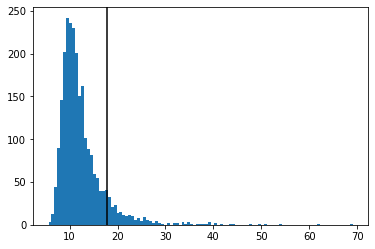

In [41]:
plt.hist(clf.decision_scores_, bins="auto")
plt.axvline(np.min(clf.decision_scores_[np.where(outliers==1)]), c='k')
plt.show()

# Angle Based

## ABOD

/Users/jacopogneri/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jacopogneri/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jacopogneri/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


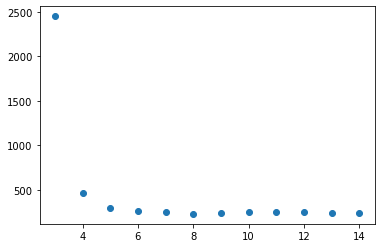

In [42]:

outliers_list_abod = []
for i in range(3,15):
    clf = ABOD(n_neighbors=i)
    clf.fit(X)
    outliers = clf.predict(X)
    outliers_list_abod.append(np.unique(outliers, return_counts=True)[1][1])

plt.scatter(x=np.arange(3,15), y=outliers_list_abod)
plt.show()


In [43]:
OS = clf.decision_scores_ #the lower the more normal
ind = np.argpartition(OS, -int(len(df)*0.01))[-int(len(df)*0.01):] # indice dei top 1% outliers
ind

array([ 361, 1283, 1497, 1720,   42, 1861, 1703,   35,  223, 1480,   33,
        841, 1957, 1862, 1556,  382, 1979, 1296, 1496, 1281, 1704, 1968,
       1702, 1766])

In [44]:
df["outliers_ABOD"] = 0
for i in range(len(df)):
    if i in ind:
        df["outliers_ABOD"][i] = -1
    else:
        df["outliers_ABOD"][i] = 1

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ABOD"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ABOD"][i] = -1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ABOD"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ABOD"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ABOD"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ABOD"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ABOD"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ABOD"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ABOD"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ABOD"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ABOD"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ABOD"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ABOD"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ABOD"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ABOD"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ABOD"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ABOD"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ABOD"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ABOD"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ABOD"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ABOD"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ABOD"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ABOD"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ABOD"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ABOD"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ABOD"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ABOD"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ABOD"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ABOD"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ABOD"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ABOD"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ABOD"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ABOD"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ABOD"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ABOD"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ABOD"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ABOD"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ABOD"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ABOD"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ABOD"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ABOD"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ABOD"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/3807823159.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["

In [45]:
df.iloc[np.where(df.outliers_ABOD == -1)]

,modality,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,sex,filename,frame_count,...,stft_q25_w4,stft_q50_w4,stft_q75_w4,stft_q95_w4,stft_q99_w4,stft_kur_w4,stft_skew_w4,outliers_LOF,outliers_CBLOF,outliers_ABOD
33,audio-only,0,1,1,1,2nd,1,0,03-01-05-02-01-02-01.wav,209810,...,0.214942,0.361178,0.620003,1.000000,1.0,-0.677069,0.674907,1,1,-1
35,audio-only,0,1,1,0,2nd,1,0,03-01-05-02-02-02-01.wav,213013,...,0.292612,0.484957,0.751114,1.000000,1.0,-1.098503,0.225204,1,1,-1
42,audio-only,0,0,1,0,1st,1,0,03-01-06-02-02-01-01.wav,190590,...,0.347175,0.513084,0.741968,1.000000,1.0,-0.961270,0.331694,-1,-1,-1
223,audio-only,0,2,0,0,2nd,3,0,03-01-03-01-02-02-03.wav,168168,...,0.365234,0.577819,0.800783,1.000000,1.0,-1.114115,0.025413,-1,1,-1
361,audio-only,0,7,1,1,2nd,4,1,03-01-07-02-01-02-04.wav,193794,...,0.486224,0.676860,0.833959,1.000000,1.0,-0.625791,-0.506131,1,-1,-1
382,audio-only,1,5,1,0,1st,4,1,03-02-02-02-02-01-04.wav,283483,...,0.000000,0.000000,0.017445,0.839625,1.0,6.294618,2.725187,-1,-1,-1
841,audio-only,0,5,1,1,2nd,9,0,03-01-02-02-01-02-09.wav,164965,...,0.689647,0.800902,0.902161,1.000000,1.0,-0.283390,-0.503471,1,-1,-1
1281,audio-only,0,1,1,1,2nd,13,0,03-01-05-02-01-02-13.wav,205005,...,0.652841,0.793504,0.914643,1.000000,1.0,0.685228,-1.070569,1,-1,-1
1283,audio-only,0,1,1,0,2nd,13,0,03-01-05-02-02-02-13.wav,200200,...,0.142245,0.236722,0.456975,1.000000,1.0,-0.232426,1.119447,1,1,-1
1296,audio-only,0,7,1,1,1st,13,0,03-01-07-02-01-01-13.wav,163363,...,0.650176,0.792217,0.895582,1.000000,1.0,-0.443681,-0.519585,-1,-1,-1


In [46]:
'''plt.hist(clf.decision_scores_, bins="auto")
plt.axvline(np.min(clf.decision_scores_[np.where(outliers==1)]), c='k')
plt.xlim((-3e-5,0.2e-5))
plt.show()'''

'plt.hist(clf.decision_scores_, bins="auto")\nplt.axvline(np.min(clf.decision_scores_[np.where(outliers==1)]), c=\'k\')\nplt.xlim((-3e-5,0.2e-5))\nplt.show()'

# Ensemble Based

## LODA

In [47]:

outliers_list_loda = []
for i in range(1,30):
    clf = LODA(n_bins="auto", n_random_cuts=i)
    clf.fit(X)
    outliers = clf.predict(X)
    outliers_list_loda.append(np.unique(outliers, return_counts=True)[1][1])


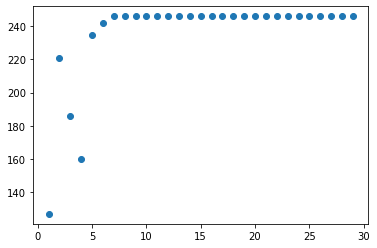

In [48]:
plt.scatter(x=np.arange(1,30), y=outliers_list_loda)
plt.show()

In [49]:
OS = clf.decision_scores_ #the lower the more normal
ind = np.argpartition(OS, -int(len(df)*0.01))[-int(len(df)*0.01):] # indice dei top 1% outliers
ind

array([2255,  908, 1766,  832, 2271, 1953,  884,  461,  841,  292,  613,
       1921, 2253,  614,  852, 2025, 2024,  589,  615,  768,  382, 1877,
       1861,  256])

In [50]:
df["outliers_LODA"] = 0
for i in range(len(df)):
    if i in ind:
        df["outliers_LODA"][i] = -1
    else:
        df["outliers_LODA"][i] = 1

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LODA"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LODA"][i] = -1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ou

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LODA"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LODA"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["out

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LODA"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LODA"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["out

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LODA"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LODA"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["out

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LODA"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LODA"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["out

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LODA"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LODA"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["out

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LODA"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LODA"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["out

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LODA"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LODA"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["out

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LODA"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LODA"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["out

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LODA"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LODA"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["out

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LODA"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LODA"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["out

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LODA"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LODA"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["out

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LODA"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LODA"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["out

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LODA"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LODA"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["out

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LODA"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LODA"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["out

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LODA"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LODA"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["out

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LODA"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LODA"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["out

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LODA"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LODA"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["out

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LODA"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LODA"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["out

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LODA"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LODA"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["out

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LODA"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_LODA"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/825742444.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["out

In [51]:
df.iloc[np.where(df.outliers_LODA == -1)]

,modality,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,sex,filename,frame_count,...,stft_q50_w4,stft_q75_w4,stft_q95_w4,stft_q99_w4,stft_kur_w4,stft_skew_w4,outliers_LOF,outliers_CBLOF,outliers_ABOD,outliers_LODA
256,audio-only,0,7,1,1,1st,3,0,03-01-07-02-01-01-03.wav,196997,...,0.496878,0.724076,1.000000,1.0,-0.949616,0.230681,1,1,1,-1
292,audio-only,1,6,1,1,1st,3,0,03-02-04-02-01-01-03.wav,224224,...,0.845093,0.959539,1.000000,1.0,0.265560,-1.229529,1,-1,1,-1
382,audio-only,1,5,1,0,1st,4,1,03-02-02-02-02-01-04.wav,283483,...,0.000000,0.017445,0.839625,1.0,6.294618,2.725187,-1,-1,-1,-1
461,audio-only,0,7,0,1,2nd,5,0,03-01-07-01-01-02-05.wav,196997,...,0.813114,0.929775,1.000000,1.0,0.321373,-1.081445,1,1,1,-1
589,audio-only,1,5,1,1,2nd,6,1,03-02-02-02-01-02-06.wav,304304,...,0.000000,0.007891,0.858079,1.0,7.127631,2.880807,-1,-1,1,-1
613,audio-only,1,1,1,1,2nd,6,1,03-02-05-02-01-02-06.wav,216216,...,0.656082,0.845108,1.000000,1.0,-1.027107,-0.410640,1,1,1,-1
614,audio-only,1,1,1,0,1st,6,1,03-02-05-02-02-01-06.wav,214614,...,0.824283,0.950402,1.000000,1.0,-0.465514,-0.985287,1,1,1,-1
615,audio-only,1,1,1,0,2nd,6,1,03-02-05-02-02-02-06.wav,216216,...,0.711078,0.884545,1.000000,1.0,-0.713260,-0.642601,1,1,1,-1
768,audio-only,0,0,1,1,1st,8,1,03-01-06-02-01-01-08.wav,190590,...,0.645752,0.867471,1.000000,1.0,-1.261727,-0.272713,1,1,1,-1
832,audio-only,0,4,0,1,1st,9,0,03-01-01-01-01-01-09.wav,156957,...,0.789872,0.906848,1.000000,1.0,-0.492959,-0.435370,1,1,1,-1


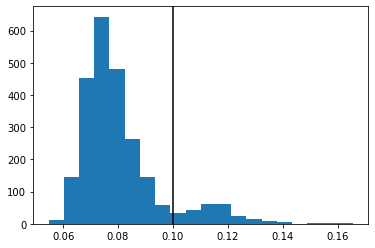

In [52]:
plt.hist(clf.decision_scores_, bins=20)
plt.axvline(np.min(clf.decision_scores_[np.where(outliers==1)]), c='k')
plt.show()

# Model Based

## Isolation Forest

In [53]:
'''
outliers_list_isoforest = []
for i in range(1,110):
    clf = IsolationForest(random_state=0, n_jobs=-1, n_estimators=i)
    clf.fit(X_train)
    outliers = clf.predict(X_test)
    outliers_list_isoforest.append(np.unique(outliers, return_counts=True)[1][0])

plt.scatter(x=np.arange(1,110), y=outliers_list_isoforest)
plt.show()
'''

'\noutliers_list_isoforest = []\nfor i in range(1,110):\n    clf = IsolationForest(random_state=0, n_jobs=-1, n_estimators=i)\n    clf.fit(X_train)\n    outliers = clf.predict(X_test)\n    outliers_list_isoforest.append(np.unique(outliers, return_counts=True)[1][0])\n\nplt.scatter(x=np.arange(1,110), y=outliers_list_isoforest)\nplt.show()\n'

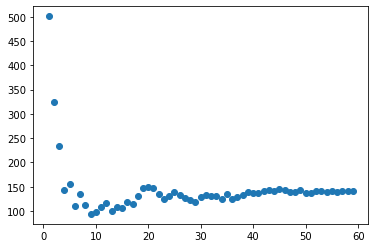

In [54]:
outliers_list_isoforest = []
for i in range(1,60):
    clf = IsolationForest(random_state=0, n_jobs=-1, n_estimators=i)
    clf.fit(X)
    outliers = clf.predict(X)
    outliers_list_isoforest.append(np.unique(outliers, return_counts=True)[1][0])

plt.scatter(x=np.arange(1,60), y=outliers_list_isoforest)
plt.show()

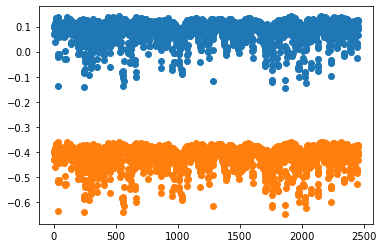

In [55]:
plt.scatter(x=np.arange(0,len(clf.decision_function(X))), y=clf.decision_function(X))
plt.scatter(x=np.arange(0,len(clf.score_samples(X))), y=clf.score_samples(X))
plt.show()
# questo vuol dire che le due funzioni vogliono dire la stessa cosa, ma decision_function è centrato attorno a zero

In [56]:
clf = IsolationForest(random_state=0, n_jobs=-1, n_estimators=35)
clf.fit(X)
outliers = clf.predict(X)

In [57]:
OS = clf.decision_function(X) #the higher the more normal
ind = np.argpartition(OS, int(len(df)*0.01))[:int(len(df)*0.01)] # indice dei top 1% outliers
ind

array([ 243, 1862,  554, 1757, 2027,   35,  287, 1861, 2024, 1283,  563,
       1759,  659, 2235, 2026, 1030, 1975, 1031,  553, 1758,  555,  242,
        240,  561])

In [58]:
OS, OS[35], OS[np.where(OS < 0)] #Outliers have decision_function values less than 0

(array([0.09514659, 0.10783411, 0.09655291, ..., 0.10091981, 0.09503038,
        0.07723263]),
 -0.16484587038171128,
 array([-2.84796584e-02, -3.61801228e-03, -1.64845870e-01, -3.92434388e-03,
        -5.99684873e-03, -9.08716733e-03, -2.56266173e-02, -2.24178263e-02,
        -7.87850952e-02, -5.84360208e-02, -8.17981799e-02, -1.51636191e-01,
        -1.28496365e-02, -2.94993190e-02, -2.95290286e-03, -4.66079993e-02,
        -3.31435230e-02, -4.55188553e-02, -1.19991019e-01, -2.32122980e-02,
        -1.17740692e-02, -5.19493431e-02, -6.98491966e-02, -1.25002268e-02,
        -4.04880281e-02, -1.10256244e-02, -6.02429003e-02, -1.92817892e-02,
        -4.61362315e-02, -3.57718499e-03, -2.38271282e-02, -5.59833623e-02,
        -3.90803417e-03, -6.97882674e-02, -8.48435456e-02, -1.27329547e-01,
        -8.90888241e-02, -7.85966009e-02, -8.98922627e-02, -1.98088824e-02,
        -1.03343374e-01, -2.35070073e-03, -3.32535136e-02, -1.44332628e-02,
        -8.80875605e-03, -1.05181172e-02, -4.7

In [59]:
df["outliers_ISOFOREST"] = 0
for i in range(len(df)):
    if i in ind:
        df["outliers_ISOFOREST"][i] = -1
    else:
        df["outliers_ISOFOREST"][i] = 1

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ISOFOREST"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ISOFOREST"][i] = -1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ISOFOREST"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ISOFOREST"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ISOFOREST"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ISOFOREST"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ISOFOREST"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ISOFOREST"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ISOFOREST"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ISOFOREST"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ISOFOREST"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ISOFOREST"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ISOFOREST"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ISOFOREST"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ISOFOREST"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ISOFOREST"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ISOFOREST"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ISOFOREST"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ISOFOREST"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ISOFOREST"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ISOFOREST"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ISOFOREST"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ISOFOREST"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ISOFOREST"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ISOFOREST"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ISOFOREST"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ISOFOREST"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ISOFOREST"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ISOFOREST"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ISOFOREST"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ISOFOREST"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ISOFOREST"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ISOFOREST"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ISOFOREST"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ISOFOREST"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ISOFOREST"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ISOFOREST"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ISOFOREST"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ISOFOREST"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ISOFOREST"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ISOFOREST"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ISOFOREST"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ISOFOREST"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["outliers_ISOFOREST"][i] = 1
/var/folders/5p/ssqpg4td2mn8_4_dm85f8n5m0000gn/T/ipykernel_3578/2040245743.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

In [60]:
df.iloc[np.where(df.outliers_ISOFOREST == -1)].head()

,modality,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,sex,filename,frame_count,...,stft_q75_w4,stft_q95_w4,stft_q99_w4,stft_kur_w4,stft_skew_w4,outliers_LOF,outliers_CBLOF,outliers_ABOD,outliers_LODA,outliers_ISOFOREST
35,audio-only,0,1,1,0,2nd,1,0,03-01-05-02-02-02-01.wav,213013,...,0.751114,1.0,1.0,-1.098503,0.225204,1,1,-1,1,-1
240,audio-only,0,1,1,1,1st,3,0,03-01-05-02-01-01-03.wav,211411,...,0.873016,1.0,1.0,-0.566148,-0.498224,1,1,1,1,-1
242,audio-only,0,1,1,0,1st,3,0,03-01-05-02-02-01-03.wav,203403,...,0.759995,1.0,1.0,-0.884069,0.155639,1,1,1,1,-1
243,audio-only,0,1,1,0,2nd,3,0,03-01-05-02-02-02-03.wav,216216,...,0.809098,1.0,1.0,-0.688100,-0.164156,1,1,1,1,-1
287,audio-only,1,2,1,0,2nd,3,0,03-02-03-02-02-02-03.wav,230630,...,0.728400,1.0,1.0,-1.023853,0.276284,1,1,1,1,-1


# Statistical approach

## Grubb's test

In [61]:
len(X)

2452

In [62]:
n = X.shape[0]
data = []
feature = 93
for i in range(X.shape[0]):
    data.append(X_unscaled[i][feature])
print(len(data))

2452


In [63]:
data = np.array(data)

In [64]:
alpha = 0.95
significance_level = alpha/(2*n)
1-significance_level

0.9998062805872757

In [65]:
t = stats.t.isf(significance_level, n-2, 2)
t

5.553422986562849

In [66]:
g_test = ((n-1) / np.sqrt(n)) * (np.sqrt(t**2 / (n-2 + t**2)))
g_test

5.518796874855831

In [67]:
relative_values = abs(data - data.mean())
index = relative_values.argmax()
value = relative_values[index]

In [68]:
g = value/data.std()

In [69]:
if g > g_test:
    print('outlier')
else:
    print('inlier')

outlier


## Likelihood Approach

In [70]:
def norm_dist(x, mu, sigma):
    return 1/(np.sqrt(2*np.pi)*sigma) * np.e**(-((x-mu)**2)/(2*sigma**2))
              
def unif_dist(x, n):
    return 1/n

In [71]:
data = []
feature = 187
for i in range(X.shape[0]):
    data.append(X_unscaled[i][feature])
print(len(data))

2452


In [72]:
M = np.copy(data)
A = []
lambda_par = 0.3

muM = np.mean(M)
sigmaM = np.std(M)
sizeA = len(A)

sumM = np.sum([norm_dist(x, muM, sigmaM) for x in M])

sumA = np.sum([unif_dist(x, sizeA) for x in A])

ll = (len(M) * np.log(1-lambda_par) + sumM + len(A) * np.log(lambda_par) + sumA)

In [73]:
M = np.copy(data)
A = []
c = 13656
for i, x in enumerate(data):
    A.append(x)
    M = np.array([xo for j, xo in enumerate(data) if i!=j])
    muM = np.mean(M)
    sigmaM = np.std(M)
    sizeA = len(A)
    sumM = np.sum([norm_dist(x, muM, sigmaM) for x in M])
    sumA = np.sum([unif_dist(x, sizeA) for x in A])
    ll_xi = (len(M) * np.log(1-lambda_par) + sumM + len(A) * np.log(lambda_par) + sumA)
    delta_ll = abs(ll - ll_xi)
    print(i, delta_ll, 'outlier' if delta_ll > c else 'inlier')
    M = np.copy(data)
    A = list()

0 55.26835605344968 inlier
1 55.84494532912504 inlier
2 60.86942264527897 inlier
3 61.39474670088384 inlier
4 53.72755222868 inlier
5 53.675435737444786 inlier
6 63.22709501211648 inlier
7 59.35701463962323 inlier
8 52.27534237908549 inlier
9 54.5419715733733 inlier
10 60.96037028165301 inlier
11 59.475794854806736 inlier
12 58.24960436188849 inlier
13 60.50720360613195 inlier
14 59.454006597719854 inlier
15 64.0851673714642 inlier
16 65.70653699729883 inlier
17 70.66468328826886 inlier
18 74.03872412610508 inlier
19 75.22991558519425 inlier
20 57.504885162750725 inlier
21 54.96320175231085 inlier
22 55.50955236359732 inlier
23 60.64583294473414 inlier
24 58.60204044393322 inlier
25 61.09249743958935 inlier
26 64.54674432202592 inlier
27 71.32608447308303 inlier
28 74.38019505998818 inlier
29 74.42268477821199 inlier
30 75.80937293008901 inlier
31 54.99569057386543 inlier
32 266.5782842525514 inlier
33 69.46867560481769 inlier
34 114.5169900773617 inlier
35 839.4513212056336 inlier
36 

289 68.51150276121916 inlier
290 75.69230508306646 inlier
291 75.39092994424573 inlier
292 73.2656243823003 inlier
293 75.01733273468562 inlier
294 73.75307323753077 inlier
295 57.8474646727409 inlier
296 64.68825779118924 inlier
297 66.9397353255481 inlier
298 29.965888257633196 inlier
299 18.515057427837746 inlier
300 10.286684701713966 inlier
301 1.0017223461909452 inlier
302 41.336871879087994 inlier
303 21.42858098304714 inlier
304 75.43288697578828 inlier
305 74.72785373893566 inlier
306 69.5832663209294 inlier
307 58.9100194524508 inlier
308 45.29922631457157 inlier
309 4.179693036712706 inlier
310 22.879217141206027 inlier
311 23.769644103304017 inlier
312 59.02121907877154 inlier
313 59.90062162930553 inlier
314 62.016255690658 inlier
315 60.04577087145299 inlier
316 58.95819202516577 inlier
317 58.184706019368605 inlier
318 67.95551627436362 inlier
319 64.85840572656889 inlier
320 57.815444651118014 inlier
321 56.73169741248421 inlier
322 66.52993467598571 inlier
323 70.11904

575 68.95925156900194 inlier
576 57.63048214705486 inlier
577 70.06414940801915 inlier
578 75.7335262264678 inlier
579 70.42323702515569 inlier
580 57.2491566533281 inlier
581 61.917295769555494 inlier
582 69.3138321871811 inlier
583 74.14745296463661 inlier
584 59.29800308338599 inlier
585 59.172117719310336 inlier
586 68.18598168851167 inlier
587 69.80326796007284 inlier
588 65.00984435877763 inlier
589 59.031642793430365 inlier
590 67.24698385872762 inlier
591 66.80925807559106 inlier
592 69.45653594026226 inlier
593 74.26924053284165 inlier
594 75.17876504913147 inlier
595 72.4149501772772 inlier
596 51.12746176640212 inlier
597 71.92269689879322 inlier
598 63.946379200264346 inlier
599 49.622591121238656 inlier
600 62.747442876847344 inlier
601 61.840967482479755 inlier
602 69.75002524920274 inlier
603 70.92840524492203 inlier
604 73.32513181719696 inlier
605 75.561782829609 inlier
606 75.37356947013177 inlier
607 71.80315005345619 inlier
608 71.25150837757974 inlier
609 74.677725

866 131.83943617818295 inlier
867 163.65735499039874 inlier
868 51.89924697295646 inlier
869 52.1671376292652 inlier
870 53.65900194577989 inlier
871 52.320655897128745 inlier
872 58.58659206084849 inlier
873 58.10817899843096 inlier
874 69.8036268443102 inlier
875 73.80534076073673 inlier
876 51.86992767380434 inlier
877 52.312472167017404 inlier
878 56.09038298329688 inlier
879 55.905409198545385 inlier
880 54.956002663617255 inlier
881 59.278308777633356 inlier
882 63.16839653273928 inlier
883 59.82773273863131 inlier
884 50.46781538147479 inlier
885 50.856255841150414 inlier
886 54.01375098002609 inlier
887 53.19089068996254 inlier
888 62.23325922594813 inlier
889 57.99793310582754 inlier
890 60.40349200660421 inlier
891 61.19879008087446 inlier
892 54.58360994729446 inlier
893 54.2713869115978 inlier
894 59.59022174295387 inlier
895 58.570543270834605 inlier
896 55.04135561377916 inlier
897 56.19733975097188 inlier
898 61.07381736036041 inlier
899 61.74076492919994 inlier
900 54.3

1162 70.98732335308159 inlier
1163 11.412049327613204 inlier
1164 69.5045449676254 inlier
1165 62.25726191178546 inlier
1166 66.47722223497112 inlier
1167 71.16924686450511 inlier
1168 75.63693456188776 inlier
1169 69.51356436194328 inlier
1170 63.75772736471845 inlier
1171 28.86448452931654 inlier
1172 69.99333443693467 inlier
1173 72.76722433684336 inlier
1174 73.09099453865201 inlier
1175 75.75737253014813 inlier
1176 24.08811154772411 inlier
1177 104.87934345418762 inlier
1178 71.32729529088829 inlier
1179 128.82029825053178 inlier
1180 75.61474627147254 inlier
1181 74.30894086039916 inlier
1182 75.53994701299234 inlier
1183 74.59571119758766 inlier
1184 26.81558252000832 inlier
1185 18.036439701972995 inlier
1186 68.01156538601208 inlier
1187 22.903763631125912 inlier
1188 65.82981517694134 inlier
1189 64.41809870113502 inlier
1190 68.11523484879581 inlier
1191 70.32585023000138 inlier
1192 73.51134021821781 inlier
1193 74.06119440609473 inlier
1194 66.73835196785512 inlier
1195 6

1438 75.44615201794659 inlier
1439 68.9256561442744 inlier
1440 73.28256697261531 inlier
1441 75.81447877567552 inlier
1442 69.55594672693405 inlier
1443 62.133654587421915 inlier
1444 124.78567574929912 inlier
1445 26.054369316567318 inlier
1446 34.090296451424365 inlier
1447 0.36486963092465885 inlier
1448 60.61569948104443 inlier
1449 64.25442395814753 inlier
1450 73.04757323818922 inlier
1451 66.46622432998265 inlier
1452 75.78534647591005 inlier
1453 75.80062417918816 inlier
1454 65.17220293628634 inlier
1455 75.33124562606099 inlier
1456 61.29743783966114 inlier
1457 58.893031195999356 inlier
1458 63.348765002330765 inlier
1459 63.2555128303793 inlier
1460 56.65753703820519 inlier
1461 57.7356826288451 inlier
1462 63.16504412671202 inlier
1463 63.36920851765899 inlier
1464 58.373861742176814 inlier
1465 58.209780914345174 inlier
1466 63.31078228884144 inlier
1467 62.79027545455028 inlier
1468 62.653049698186805 inlier
1469 62.96061147842556 inlier
1470 68.91198201209772 inlier
14

1714 63.80245804130391 inlier
1715 69.03156776087417 inlier
1716 74.83057016857492 inlier
1717 70.82046008034376 inlier
1718 75.68013285096094 inlier
1719 75.55865534720942 inlier
1720 64.06848786384217 inlier
1721 73.70735970775422 inlier
1722 24.114637144011795 inlier
1723 0.013267980801174417 inlier
1724 68.0808671177947 inlier
1725 67.41514227732841 inlier
1726 64.80276524479268 inlier
1727 68.81552612574887 inlier
1728 60.80004146581632 inlier
1729 63.78191586052708 inlier
1730 69.28077068422863 inlier
1731 66.749894918059 inlier
1732 60.314557873731246 inlier
1733 57.443744706804864 inlier
1734 61.216114249415114 inlier
1735 58.85471883407445 inlier
1736 73.4063102582586 inlier
1737 75.59867841316736 inlier
1738 72.43775370845105 inlier
1739 75.46898803197837 inlier
1740 57.863257365243044 inlier
1741 23.609623460797593 inlier
1742 53.816040972145856 inlier
1743 42.1541591296409 inlier
1744 68.88075282884529 inlier
1745 61.49680552036443 inlier
1746 71.25609165086644 inlier
1747 

1993 66.58940848603379 inlier
1994 72.4891684562026 inlier
1995 70.10398937016726 inlier
1996 61.49943725935009 inlier
1997 63.81289114890387 inlier
1998 73.83435594486946 inlier
1999 66.73668256457313 inlier
2000 61.61901260995364 inlier
2001 62.7146839031484 inlier
2002 65.37091181821597 inlier
2003 67.89269704958133 inlier
2004 75.49309574777726 inlier
2005 75.20558576958138 inlier
2006 73.66593075345736 inlier
2007 72.98059991640912 inlier
2008 23.679227635730058 inlier
2009 44.0313209478918 inlier
2010 42.87773826517514 inlier
2011 15.85623432288412 inlier
2012 58.46171665395377 inlier
2013 60.59754836074717 inlier
2014 65.74345905885275 inlier
2015 63.315749493427575 inlier
2016 63.85225904741674 inlier
2017 74.56436918897089 inlier
2018 70.13657207705546 inlier
2019 67.24075287372398 inlier
2020 55.57896057100152 inlier
2021 68.81128849381639 inlier
2022 75.71877390742884 inlier
2023 73.37132744549308 inlier
2024 163.87499348202255 inlier
2025 104.1834513333597 inlier
2026 155.6

2270 68.92523542960407 inlier
2271 61.046093142416794 inlier
2272 75.45680332796474 inlier
2273 75.73263370597851 inlier
2274 71.11026739285444 inlier
2275 72.33514095866121 inlier
2276 9.593417474578018 inlier
2277 32.85343715433555 inlier
2278 170.859479370818 inlier
2279 86.84677286166698 inlier
2280 73.4999961014837 inlier
2281 62.793108219164424 inlier
2282 69.83485393700539 inlier
2283 68.75503470453259 inlier
2284 73.24649417045293 inlier
2285 74.40161555974919 inlier
2286 42.11047398584196 inlier
2287 54.296381425490836 inlier
2288 70.79025493025256 inlier
2289 68.225008498237 inlier
2290 75.5253037099028 inlier
2291 75.08921494887909 inlier
2292 75.28942551743239 inlier
2293 75.65211615155567 inlier
2294 65.65658002076088 inlier
2295 33.75544790553977 inlier
2296 75.6564815754682 inlier
2297 74.79957138525788 inlier
2298 72.9663924294 inlier
2299 74.41667099943152 inlier
2300 71.9144829515717 inlier
2301 75.06663988402579 inlier
2302 40.54008210840402 inlier
2303 70.0064830111

# Deviation Based

In [74]:
def sf(x, X):
    idx = list(X).index(x)
    X1 = np.array([x1 for i, x1 in enumerate(X) if i != idx])
    return np.abs(np.var(X) - np.var(X1))

In [75]:
for i, x in enumerate(data):
    print(i, sf(x, data))

0 5.23947052703046e-09
1 5.582477675044879e-09
2 8.520243848716697e-09
3 8.82276433138027e-09
4 4.316189158089668e-09
5 4.284785237108533e-09
6 9.872633973903068e-09
7 7.644848068255388e-09
8 3.4366970859969976e-09
9 4.805437036743091e-09
10 8.572672030290939e-09
11 7.713852448705332e-09
12 6.999278603480718e-09
13 8.31120608822672e-09
14 7.701198106524823e-09
15 1.0361902108780218e-08
16 1.1283626232055585e-08
17 1.4113210069062682e-08
18 1.6157552973876258e-08
19 1.79671622969153e-08
20 6.5627728641982e-09
21 5.0573961581700595e-09
22 5.383117218258834e-09
23 8.391253616138678e-09
24 7.20517862503456e-09
25 8.648798187162513e-09
26 1.0624606518370668e-08
27 1.4498732322093262e-08
28 1.6385484505232104e-08
29 1.790216632354953e-08
30 1.7776469729045646e-08
31 1.202010627248789e-08
32 2.6385948400783687e-07
33 6.288464101407551e-08
34 1.0463792917456382e-07
35 8.895033708737558e-07
36 1.0251324448531647e-08
37 9.555992182028552e-09
38 1.197218018629255e-08
39 1.1820978474395318e-08
40 

314 9.179744970663393e-09
315 8.04436013361918e-09
316 7.412822434252038e-09
317 6.961317121120911e-09
318 1.2560702508239733e-08
319 1.0801829784584313e-08
320 6.745041740710501e-09
321 6.107454827546923e-09
322 1.1751001189842173e-08
323 1.3797775473437055e-08
324 1.0875905999561052e-08
325 1.373595857190454e-08
326 1.7420246784376225e-08
327 1.6698431491557052e-08
328 1.6425563878490104e-08
329 4.708878030983989e-09
330 5.431212847612442e-09
331 4.712418642825923e-08
332 7.45337991082544e-09
333 1.690459190128459e-08
334 1.7958218673119644e-08
335 1.6595302458689604e-08
336 1.7892764345790908e-08
337 1.7615351895567874e-08
338 2.196412732868516e-08
339 9.39235095537424e-09
340 1.7780523502448757e-08
341 1.7802695390661968e-08
342 7.762281176286218e-09
343 1.6724458197920873e-08
344 2.0160016668183513e-07
345 1.1793635371534073e-07
346 4.891959310018254e-07
347 8.192610732813543e-08
348 1.6659218118021614e-08
349 1.7870123039074063e-08
350 1.2435927010383426e-08
351 1.051672631258485

635 5.0656762470851916e-09
636 5.00148245815592e-09
637 6.009114113245183e-09
638 8.719165607095172e-09
639 8.719165607095172e-09
640 1.796176164211129e-08
641 1.7733260677250918e-08
642 1.7898482129540634e-08
643 1.4653169697158828e-08
644 3.779921903271041e-09
645 4.709724821347783e-09
646 6.011012832376052e-09
647 1.0371278641228647e-08
648 8.642631854872626e-09
649 8.716768189198643e-09
650 1.7000932905177947e-08
651 1.4986637127267105e-08
652 1.7853503804697254e-08
653 5.428773269531878e-09
654 1.4470245139685883e-08
655 1.7845457900191996e-08
656 3.8333629526398824e-08
657 8.72250868295336e-08
658 4.5918165729631885e-07
659 4.2641742782759996e-07
660 7.11686744133105e-09
661 6.836701372919514e-09
662 1.3337584232555764e-08
663 1.1039100974164482e-08
664 1.4373831974155509e-08
665 1.6383714421423843e-08
666 2.2492002360619825e-08
667 6.1282184544961846e-09
668 6.168779828146203e-09
669 7.918990902129922e-09
670 8.167066303293644e-09
671 1.3958868784328445e-08
672 1.680908129732191

961 1.5032628259888396e-08
962 1.7964677211535635e-08
963 1.7178222590524697e-08
964 1.611517316692354e-08
965 1.2325529688856783e-08
966 1.3527227334647195e-08
967 1.1854017341847466e-08
968 7.467917813078185e-08
969 4.0669696070239005e-08
970 2.2735543708365187e-07
971 1.4879870423613724e-07
972 1.7928221123197615e-08
973 1.4308601920165118e-08
974 1.775710586379806e-08
975 1.789550219964594e-08
976 1.3045820246029513e-08
977 1.51046609996535e-08
978 3.838367913733211e-09
979 1.708442192035163e-08
980 1.1706259734137192e-08
981 1.546232705693367e-08
982 1.776601157513761e-08
983 7.950980939125992e-09
984 1.4289559697918666e-08
985 7.929566925009377e-09
986 1.4058675983061905e-08
987 8.102977390162089e-09
988 1.7854416015237377e-08
989 1.5484200676887288e-08
990 1.1569343323948058e-08
991 1.780282475193247e-08
992 9.752107200445594e-09
993 1.479569771265139e-08
994 2.000067779043467e-08
995 2.8735468994530767e-08
996 1.7821527334038365e-08
997 1.757473938051473e-08
998 1.6094944359551

1322 1.4343279545878844e-08
1323 1.3571961264288257e-08
1324 1.0024843540935911e-08
1325 1.2452750944644394e-08
1326 1.7169689152638802e-08
1327 1.6446390225173014e-08
1328 4.9135324139358e-09
1329 3.4757921632362827e-09
1330 8.50477513067438e-09
1331 8.799958548496906e-09
1332 5.5132287815466176e-09
1333 7.044319832799021e-09
1334 7.4184204610548915e-09
1335 8.761433871511343e-09
1336 1.1957011496712051e-08
1337 1.0858703925445314e-08
1338 1.5373780080453795e-08
1339 1.3997094517881066e-08
1340 1.7306864621871414e-08
1341 1.7556344680776982e-08
1342 1.7056883516211303e-08
1343 1.4776761721665434e-08
1344 5.936619163836689e-09
1345 7.529131983070078e-09
1346 8.610353249370714e-09
1347 8.353829781931595e-09
1348 1.1086820545575438e-08
1349 1.3314249318368198e-08
1350 1.60255027253464e-08
1351 1.6628398001732893e-08
1352 6.203866295541956e-09
1353 4.172944704918609e-09
1354 8.888690126991714e-09
1355 6.6513485524115844e-09
1356 5.733270081445172e-09
1357 4.469493870845479e-09
1358 1.0399

1644 1.697503760335849e-08
1645 1.621715057430412e-08
1646 1.7022248804357976e-08
1647 1.6207664704464392e-08
1648 1.3977008235485134e-08
1649 1.7493318953744645e-08
1650 1.7745495208801483e-08
1651 1.5737505050328695e-08
1652 1.7715890249841364e-08
1653 1.749626036536494e-08
1654 2.179374184494798e-08
1655 2.9482400039709746e-09
1656 1.7399352177212225e-08
1657 1.629304546417091e-08
1658 1.6804194804832242e-08
1659 1.67871377816325e-08
1660 1.7966950238083434e-08
1661 1.7697506121854066e-08
1662 8.595353191134456e-10
1663 9.661132121562064e-09
1664 7.757702556440758e-09
1665 6.99620356756119e-09
1666 1.0219436991406444e-08
1667 9.140699386352038e-09
1668 6.791843372738369e-09
1669 7.412600264184593e-09
1670 1.0517944864489473e-08
1671 1.3294063210984581e-08
1672 6.94037063478809e-09
1673 4.968150862757939e-09
1674 1.0426329003697344e-08
1675 7.81468787076911e-09
1676 9.76135698448977e-09
1677 1.1489199655743379e-08
1678 1.7877689415005625e-08
1679 1.4578647403705198e-08
1680 1.7305780

2001 9.579800600684717e-09
2002 1.1093038130229765e-08
2003 1.2524977040096591e-08
2004 1.7240586587209054e-08
2005 1.7967190666671117e-08
2006 1.7777717704638683e-08
2007 1.7639300273286174e-08
2008 2.78279337686811e-08
2009 4.230873616778614e-08
2010 7.380225935462207e-09
2011 4.830573076009545e-09
2012 7.123249645456318e-09
2013 8.363379334534e-09
2014 1.130458857319177e-08
2015 9.923245275755008e-09
2016 1.0229223184421248e-08
2017 1.6512269685629237e-08
2018 1.3807878690643316e-08
2019 1.2154523859222554e-08
2020 1.2229909605905999e-08
2021 1.656549501415208e-08
2022 1.7881662428967176e-08
2023 1.7720536999020107e-08
2024 1.5477644942288988e-07
2025 9.460030326023547e-08
2026 1.4619770084283346e-07
2027 3.556669913091408e-07
2028 4.206991081537456e-09
2029 9.703238934139467e-09
2030 8.881040290742231e-09
2031 1.1558109510169216e-08
2032 1.5935463991729602e-09
2033 1.2205857606127494e-08
2034 2.8273280880909885e-08
2035 8.226312260527777e-09
2036 1.1596915510967494e-08
2037 9.92421

2299 1.7901345769089376e-08
2300 1.739430911196297e-08
2301 1.79639890207864e-08
2302 6.425780744564384e-09
2303 1.6899818267695208e-08
2304 9.748485656117334e-09
2305 1.032422477109001e-08
2306 1.4839207691840287e-08
2307 1.2831371483902816e-08
2308 8.656733205459786e-09
2309 1.079654471725154e-08
2310 1.4646702617608187e-08
2311 1.3374750845089687e-08
2312 8.27393220437071e-09
2313 1.1134292468533813e-08
2314 9.44430898122125e-09
2315 1.2666070122673934e-08
2316 1.535052081035385e-08
2317 1.3704617365927223e-08
2318 1.7934611776883108e-08
2319 1.7582442168771414e-08
2320 1.6944580157887083e-08
2321 1.7468479556542944e-08
2322 9.725216046807972e-09
2323 1.0029809652903094e-08
2324 1.1521068423005286e-08
2325 1.2368014365420489e-08
2326 1.6771197273990606e-08
2327 1.3754774013053023e-08
2328 1.4124342102827256e-08
2329 1.2788757145968223e-08
2330 1.2577318753125564e-08
2331 1.2487470619607945e-08
2332 9.412159433894347e-09
2333 1.7871485604455497e-08
2334 1.3318480972383296e-08
2335 1.

In [76]:
np.var(data)

4.403761478789443e-05

# Outliers Visualization through Dimensionality Reduction

In [77]:
df.head()

,modality,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,sex,filename,frame_count,...,stft_q75_w4,stft_q95_w4,stft_q99_w4,stft_kur_w4,stft_skew_w4,outliers_LOF,outliers_CBLOF,outliers_ABOD,outliers_LODA,outliers_ISOFOREST
0,audio-only,0,4,0,1,1st,1,0,03-01-01-01-01-01-01.wav,158558,...,0.896606,1.0,1.0,6.742190,-1.706215,1,1,1,1,1
1,audio-only,0,4,0,1,2nd,1,0,03-01-01-01-01-02-01.wav,160160,...,0.874713,1.0,1.0,-0.700420,-0.201495,1,1,1,1,1
2,audio-only,0,4,0,0,1st,1,0,03-01-01-01-02-01-01.wav,156956,...,0.899156,1.0,1.0,1.688986,-1.024773,1,1,1,1,1
3,audio-only,0,4,0,0,2nd,1,0,03-01-01-01-02-02-01.wav,152152,...,0.886474,1.0,1.0,-0.594111,-0.412871,1,1,1,1,1
4,audio-only,0,5,0,1,1st,1,0,03-01-02-01-01-01-01.wav,169769,...,0.878014,1.0,1.0,0.126535,-0.620782,1,1,1,1,1


## ISOMAP

In [78]:
from sklearn.manifold import Isomap

In [79]:
iso = Isomap(n_components=2)
X_iso = iso.fit_transform(X)
X_iso.shape

/Users/jacopogneri/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:324: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Users/jacopogneri/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


(2452, 2)

### LOF

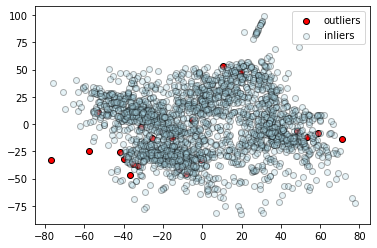

In [80]:
plt.scatter(X_iso[np.where(df.outliers_LOF == -1), 0], X_iso[np.where(df.outliers_LOF == -1), 1], edgecolor='k', alpha=1, label = "outliers", color = "red")
plt.scatter(X_iso[np.where(df.outliers_LOF == 1), 0], X_iso[np.where(df.outliers_LOF == 1), 1], edgecolor='k', alpha=0.3, label = "inliers", color = "lightblue")
plt.legend()
plt.show()

### CBLOF

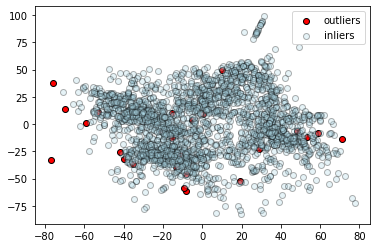

In [81]:
plt.scatter(X_iso[np.where(df.outliers_CBLOF == -1), 0], X_iso[np.where(df.outliers_CBLOF == -1), 1], edgecolor='k', alpha=1, label = "outliers", color = "red")
plt.scatter(X_iso[np.where(df.outliers_CBLOF == 1), 0], X_iso[np.where(df.outliers_CBLOF == 1), 1], edgecolor='k', alpha=0.3, label = "inliers", color = "lightblue")
plt.legend()
plt.show()

### ABOD

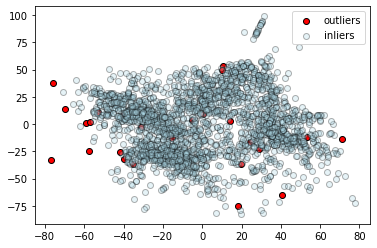

In [82]:
plt.scatter(X_iso[np.where(df.outliers_ABOD == -1), 0], X_iso[np.where(df.outliers_ABOD == -1), 1], edgecolor='k', alpha=1, label = "outliers", color = "red")
plt.scatter(X_iso[np.where(df.outliers_ABOD == 1), 0], X_iso[np.where(df.outliers_ABOD == 1), 1], edgecolor='k', alpha=0.3, label = "inliers", color = "lightblue")
plt.legend()
plt.show()

### LODA

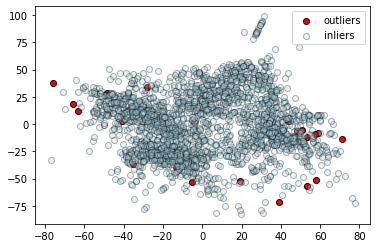

In [83]:
plt.scatter(X_iso[np.where(df.outliers_LODA == -1), 0], X_iso[np.where(df.outliers_LODA == -1), 1], edgecolor='k', alpha=1, label = "outliers", color = "red")
plt.scatter(X_iso[np.where(df.outliers_LODA == 1), 0], X_iso[np.where(df.outliers_LODA == 1), 1], edgecolor='k', alpha=0.3, label = "inliers", color = "lightblue")
plt.legend()
plt.show()

### ISOFOREST

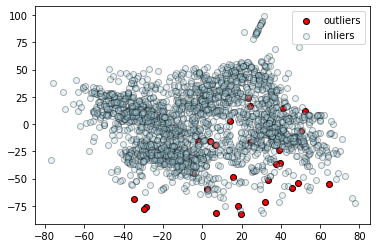

In [84]:
plt.scatter(X_iso[np.where(df.outliers_ISOFOREST == -1), 0], X_iso[np.where(df.outliers_ISOFOREST == -1), 1], edgecolor='k', alpha=1, label = "outliers", color = "red")
plt.scatter(X_iso[np.where(df.outliers_ISOFOREST == 1), 0], X_iso[np.where(df.outliers_ISOFOREST == 1), 1], edgecolor='k', alpha=0.3, label = "inliers", color = "lightblue")
plt.legend()
plt.show()

## T-SNE

In [85]:
from sklearn.manifold import TSNE

In [86]:
tsne = TSNE(n_components=2, learning_rate="auto", init="pca")
X_tsne = tsne.fit_transform(X)
X_tsne.shape

/Users/jacopogneri/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


(2452, 2)

### LOF

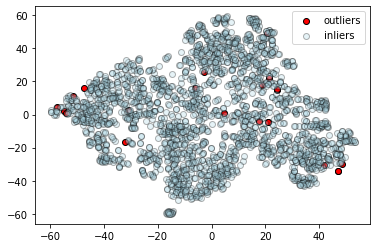

In [87]:
plt.scatter(X_tsne[np.where(df.outliers_LODA == -1), 0], X_tsne[np.where(df.outliers_LODA == -1), 1], edgecolor='k', alpha=1, label = "outliers", color = "red")
plt.scatter(X_tsne[np.where(df.outliers_LODA == 1), 0], X_tsne[np.where(df.outliers_LODA == 1), 1], edgecolor='k', alpha=0.3, label = "inliers", color = "lightblue")
plt.legend()
plt.show()

### CBLOF

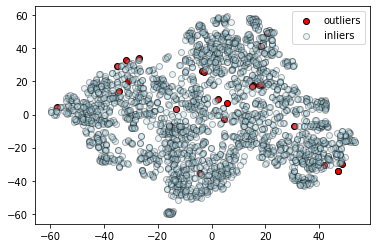

In [88]:
plt.scatter(X_tsne[np.where(df.outliers_CBLOF == -1), 0], X_tsne[np.where(df.outliers_CBLOF == -1), 1], edgecolor='k', alpha=1, label = "outliers", color = "red")
plt.scatter(X_tsne[np.where(df.outliers_CBLOF == 1), 0], X_tsne[np.where(df.outliers_CBLOF == 1), 1], edgecolor='k', alpha=0.3, label = "inliers", color = "lightblue")
plt.legend()
plt.show()

### ABOD

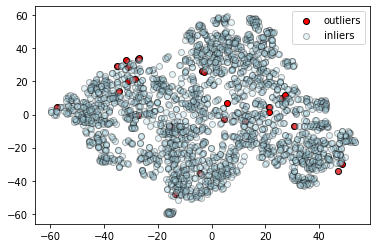

In [89]:
plt.scatter(X_tsne[np.where(df.outliers_ABOD == -1), 0], X_tsne[np.where(df.outliers_ABOD == -1), 1], edgecolor='k', alpha=1, label = "outliers", color = "red")
plt.scatter(X_tsne[np.where(df.outliers_ABOD == 1), 0], X_tsne[np.where(df.outliers_ABOD == 1), 1], edgecolor='k', alpha=0.3, label = "inliers", color = "lightblue")
plt.legend()
plt.show()

### LODA

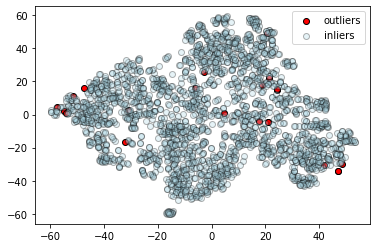

In [90]:
plt.scatter(X_tsne[np.where(df.outliers_LODA == -1), 0], X_tsne[np.where(df.outliers_LODA == -1), 1], edgecolor='k', alpha=1, label = "outliers", color = "red")
plt.scatter(X_tsne[np.where(df.outliers_LODA == 1), 0], X_tsne[np.where(df.outliers_LODA == 1), 1], edgecolor='k', alpha=0.3, label = "inliers", color = "lightblue")
plt.legend()
plt.show()

### ISOFOREST

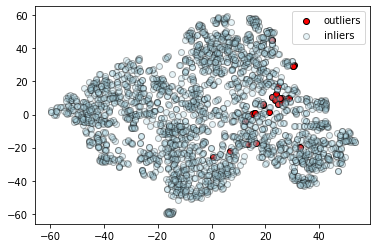

In [91]:
plt.scatter(X_tsne[np.where(df.outliers_ISOFOREST == -1), 0], X_tsne[np.where(df.outliers_ISOFOREST == -1), 1], edgecolor='k', alpha=1, label = "outliers", color = "red")
plt.scatter(X_tsne[np.where(df.outliers_ISOFOREST == 1), 0], X_tsne[np.where(df.outliers_ISOFOREST == 1), 1], edgecolor='k', alpha=0.3, label = "inliers", color = "lightblue")
plt.legend()
plt.show()

## Multi Dimensional Scaling

In [92]:
from sklearn.manifold import MDS

In [93]:
mds = MDS(n_components=2) #, normalized_stress='auto') # shoudl run as sammon mapping
X_mds = mds.fit_transform(X)
X_mds.shape

(2452, 2)

### LOF

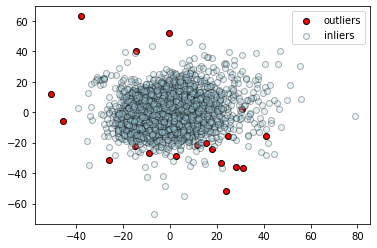

In [94]:
plt.scatter(X_mds[np.where(df.outliers_LOF == -1), 0], X_mds[np.where(df.outliers_LOF == -1), 1], edgecolor='k', alpha=1, label = "outliers", color = "red")
plt.scatter(X_mds[np.where(df.outliers_LOF == 1), 0], X_mds[np.where(df.outliers_LOF == 1), 1], edgecolor='k', alpha=0.3, label = "inliers", color = "lightblue")
plt.legend()
plt.show()

### CBLOF

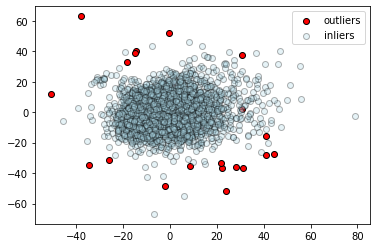

In [95]:
plt.scatter(X_mds[np.where(df.outliers_CBLOF == -1), 0], X_mds[np.where(df.outliers_CBLOF == -1), 1], edgecolor='k', alpha=1, label = "outliers", color = "red")
plt.scatter(X_mds[np.where(df.outliers_CBLOF == 1), 0], X_mds[np.where(df.outliers_CBLOF == 1), 1], edgecolor='k', alpha=0.3, label = "inliers", color = "lightblue")
plt.legend()
plt.show()

### ABOD

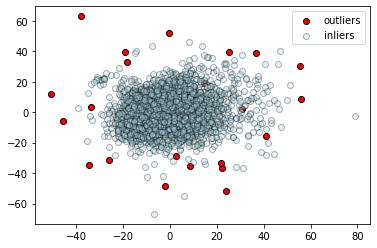

In [96]:
plt.scatter(X_mds[np.where(df.outliers_ABOD == -1), 0], X_mds[np.where(df.outliers_ABOD == -1), 1], edgecolor='k', alpha=1, label = "outliers", color = "red")
plt.scatter(X_mds[np.where(df.outliers_ABOD == 1), 0], X_mds[np.where(df.outliers_ABOD == 1), 1], edgecolor='k', alpha=0.3, label = "inliers", color = "lightblue")
plt.legend()
plt.show()

### LODA

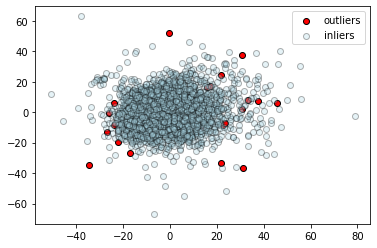

In [97]:
plt.scatter(X_mds[np.where(df.outliers_LODA == -1), 0], X_mds[np.where(df.outliers_LODA == -1), 1], edgecolor='k', alpha=1, label = "outliers", color = "red")
plt.scatter(X_mds[np.where(df.outliers_LODA == 1), 0], X_mds[np.where(df.outliers_LODA == 1), 1], edgecolor='k', alpha=0.3, label = "inliers", color = "lightblue")
plt.legend()
plt.show()

### ISOFOREST

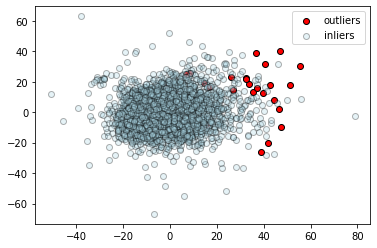

In [98]:
plt.scatter(X_mds[np.where(df.outliers_ISOFOREST == -1), 0], X_mds[np.where(df.outliers_ISOFOREST == -1), 1], edgecolor='k', alpha=1, label = "outliers", color = "red")
plt.scatter(X_mds[np.where(df.outliers_ISOFOREST == 1), 0], X_mds[np.where(df.outliers_ISOFOREST == 1), 1], edgecolor='k', alpha=0.3, label = "inliers", color = "lightblue")
plt.legend()
plt.show()

## Principal Component Analysis

In [99]:
from sklearn.decomposition import PCA

In [100]:
pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)

### LOF

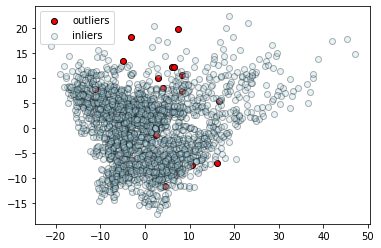

In [101]:
plt.scatter(X_pca[np.where(df.outliers_LOF == -1), 0], X_pca[np.where(df.outliers_LOF == -1), 1], edgecolor='k', alpha=1, label = "outliers", color = "red")
plt.scatter(X_pca[np.where(df.outliers_LOF == 1), 0], X_pca[np.where(df.outliers_LOF == 1), 1], edgecolor='k', alpha=0.3, label = "inliers", color = "lightblue")
plt.legend()
plt.show()

### CBLOF

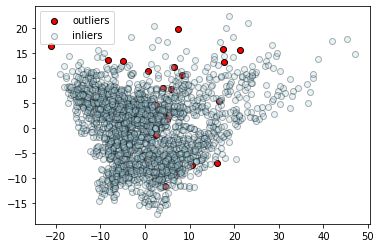

In [102]:
plt.scatter(X_pca[np.where(df.outliers_CBLOF == -1), 0], X_pca[np.where(df.outliers_CBLOF == -1), 1], edgecolor='k', alpha=1, label = "outliers", color = "red")
plt.scatter(X_pca[np.where(df.outliers_CBLOF == 1), 0], X_pca[np.where(df.outliers_CBLOF == 1), 1], edgecolor='k', alpha=0.3, label = "inliers", color = "lightblue")
plt.legend()
plt.show()

### ABOD

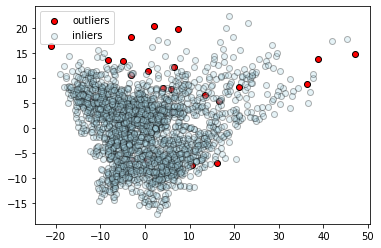

In [103]:
plt.scatter(X_pca[np.where(df.outliers_ABOD == -1), 0], X_pca[np.where(df.outliers_ABOD == -1), 1], edgecolor='k', alpha=1, label = "outliers", color = "red")
plt.scatter(X_pca[np.where(df.outliers_ABOD == 1), 0], X_pca[np.where(df.outliers_ABOD == 1), 1], edgecolor='k', alpha=0.3, label = "inliers", color = "lightblue")
plt.legend()
plt.show()

### LODA

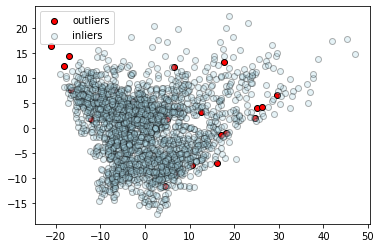

In [104]:
plt.scatter(X_pca[np.where(df.outliers_LODA == -1), 0], X_pca[np.where(df.outliers_LODA == -1), 1], edgecolor='k', alpha=1, label = "outliers", color = "red")
plt.scatter(X_pca[np.where(df.outliers_LODA == 1), 0], X_pca[np.where(df.outliers_LODA == 1), 1], edgecolor='k', alpha=0.3, label = "inliers", color = "lightblue")
plt.legend()
plt.show()

### ISOFOREST

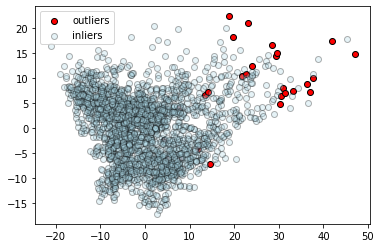

In [105]:
plt.scatter(X_pca[np.where(df.outliers_ISOFOREST == -1), 0], X_pca[np.where(df.outliers_ISOFOREST == -1), 1], edgecolor='k', alpha=1, label = "outliers", color = "red")
plt.scatter(X_pca[np.where(df.outliers_ISOFOREST == 1), 0], X_pca[np.where(df.outliers_ISOFOREST == 1), 1], edgecolor='k', alpha=0.3, label = "inliers", color = "lightblue")
plt.legend()
plt.show()